# MNIST

In [1]:
from fastai.vision.all import *

Get MNIST sample data

In [2]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/storage/data/mnist_sample')

Change base path to path and list files

In [4]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
(path/'train'/'7').ls()

(#6265) [Path('train/7/32208.png'),Path('train/7/79.png'),Path('train/7/54193.png'),Path('train/7/4545.png'),Path('train/7/2161.png'),Path('train/7/11473.png'),Path('train/7/3914.png'),Path('train/7/58565.png'),Path('train/7/8302.png'),Path('train/7/59871.png')...]

Create lists with locations of images for 3 and 7

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [8]:
im = Image.open(threes[1])
im

Some experimentation with data

In [9]:
array(im)[4:12,4:12]

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29, 150, 195],
       [  0,   0,   0,  48, 166, 224, 253, 253],
       [  0,  93, 244, 249, 253, 187,  46,  10],
       [  0, 107, 253, 253, 230,  48,   0,   0],
       [  0,   3,  20,  20,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  14]], dtype=uint8)

In [10]:
tensor(im)[4:12,4:12]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29, 150, 195],
        [  0,   0,   0,  48, 166, 224, 253, 253],
        [  0,  93, 244, 249, 253, 187,  46,  10],
        [  0, 107, 253, 253, 230,  48,   0,   0],
        [  0,   3,  20,  20,  15,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  14]], dtype=torch.uint8)

In [11]:
three_df = pd.DataFrame(tensor(im)[4:20,4:20])
three_df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2


### Simple approach to identify pictures

In [12]:
threes_list = [tensor(Image.open(o)) for o in threes]
sevens_list = [tensor(Image.open(o)) for o in sevens]
len(threes_list), len(sevens_list)

(6131, 6265)

<AxesSubplot:>

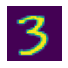

In [13]:
show_image(threes_list[1])

In [14]:
max([int(threes_list[i].max()) for i in range(len(threes_list))])

255

In [15]:
threes_stacked = torch.stack(threes_list).float()/255
sevens_stacked = torch.stack(sevens_list).float()/255
threes_stacked.shape, sevens_stacked.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

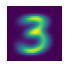

In [16]:
avg_three = threes_stacked.mean(0)
show_image(avg_three)

<AxesSubplot:>

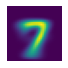

In [17]:
avg_seven = sevens_stacked.mean(0)
show_image(avg_seven)

Take one image and find diffences

In [18]:
(path/'valid'/'3').ls()

(#1010) [Path('valid/3/5309.png'),Path('valid/3/9812.png'),Path('valid/3/5635.png'),Path('valid/3/2072.png'),Path('valid/3/3094.png'),Path('valid/3/7075.png'),Path('valid/3/2069.png'),Path('valid/3/4638.png'),Path('valid/3/991.png'),Path('valid/3/323.png')...]

In [19]:
test_image = Image.open((path/'valid'/'3'/'5309.png'))
test_image

In [20]:
test_image_fin = (tensor(test_image).float()/255)

Find the error terms

In [21]:
l1_with_3 = (test_image_fin - avg_three).abs().mean()
l1_with_7 = (test_image_fin - avg_seven).abs().mean()
l1_with_3, l1_with_7

(tensor(0.1290), tensor(0.1769))

In [22]:
l2_with_3 = ((test_image_fin - avg_three)**2).abs().mean()
l2_with_7 = ((test_image_fin - avg_seven)**2).abs().mean()
l2_with_3, l2_with_7

(tensor(0.0561), tensor(0.1071))

### Score all the images using simple logic to find accuracy

In [23]:
valid_threes_paths = (path/'valid'/'3').ls()
valid_sevens_paths = (path/'valid'/'7').ls()
len(valid_threes_paths), len(valid_sevens_paths)

(1010, 1028)

In [24]:
valid_threes = torch.stack([tensor(Image.open(p)) for p in valid_threes_paths])
valid_sevens = torch.stack([tensor(Image.open(p)) for p in valid_sevens_paths])
valid_threes.shape, valid_sevens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

<AxesSubplot:>

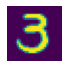

In [25]:
show_image(valid_threes[0])

In [26]:
valid3_losss_w3 = (valid_threes-avg_three).abs().mean((-1,-2))
valid3_losss_w7 = (valid_threes-avg_seven).abs().mean((-1,-2))
valid7_losss_w3 = (valid_sevens-avg_three).abs().mean((-1,-2))
valid7_losss_w7 = (valid_sevens-avg_seven).abs().mean((-1,-2))
valid3_losss_w3.shape, valid3_losss_w7.shape, valid3_losss_w7.shape, valid7_losss_w7.shape

(torch.Size([1010]),
 torch.Size([1010]),
 torch.Size([1010]),
 torch.Size([1028]))

In [27]:
accuracy_3 = sum(valid3_losss_w3 < valid3_losss_w7)/len(valid3_losss_w3)
accuracy_7 = sum(valid7_losss_w7 < valid7_losss_w3)/len(valid7_losss_w7)
accuracy_tot = (sum(valid3_losss_w3 < valid3_losss_w7)+sum(valid7_losss_w7 < valid7_losss_w3))/(len(valid3_losss_w3)+len(valid7_losss_w7))
accuracy_3, accuracy_7, accuracy_tot

(tensor(0.9436), tensor(0.9815), tensor(0.9627))

### Stocastic Gradient Descent

In [28]:
from fastbook import *

In [29]:
def f(x): return x**2

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


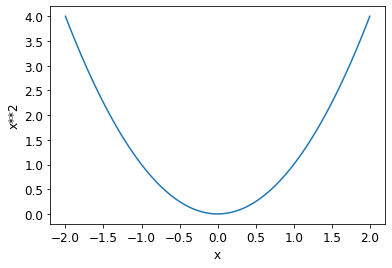

In [30]:
plot_function(f, 'x', 'x**2')

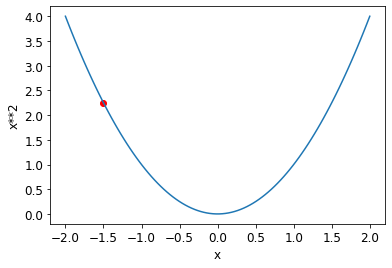

In [31]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [32]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [33]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [34]:
yt.backward()

In [35]:
xt.grad

tensor(6.)

In [36]:
xt = tensor([2.,3.,4.]).requires_grad_()
xt

tensor([2., 3., 4.], requires_grad=True)

In [37]:
yt = f(xt).sum()
yt

tensor(29., grad_fn=<SumBackward0>)

In [38]:
yt.backward()
xt.grad

tensor([4., 6., 8.])

### End-to-End SGD

In [39]:
time = torch.arange(20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

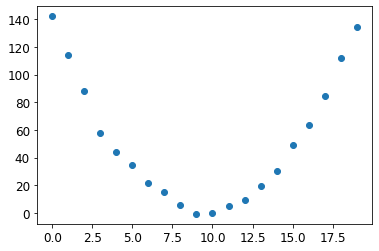

In [40]:
speed = 1.5*(time-9.5)**2 + 1 + torch.randn(20)*3
plt.scatter(time, speed)

In [41]:
def f(t, params):
    a,b,c = params
    return (a*t**2) + (b*t) + c

In [42]:
def mse(pred, actual): return ((pred-actual)**2).mean().sqrt()

**Step 1: Initialize Parameters**

In [43]:
params = torch.randn(3).requires_grad_()
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [44]:
orig_params  = params.clone()
orig_params

tensor([-0.7658, -0.7506,  1.3525], grad_fn=<CloneBackward>)

**Step2: Calculate Predictions**

In [45]:
pred = f(time, params)
pred

tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)

In [46]:
def show_preds(pred, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(pred), color='red')

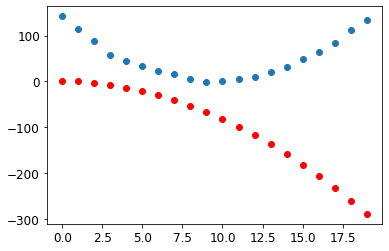

In [47]:
show_preds(pred)

**Step3: Calculate Loss**

In [48]:
loss = mse(pred, speed)
loss

tensor(187.8580, grad_fn=<SqrtBackward>)

**Step4: Calculate Gradients**

In [49]:
loss.backward()
params.grad

tensor([-161.4840,  -10.3630,   -0.8085])

**Step5: Step the weights**

In [50]:
lr = 1e-3
params.data -= lr*params.grad.data
params.grad = None

In [51]:
params

tensor([-0.6044, -0.7403,  1.3534], requires_grad=True)

In [52]:
pred = f(time, params)

In [53]:
mse(pred, speed)

tensor(161.8400, grad_fn=<SqrtBackward>)

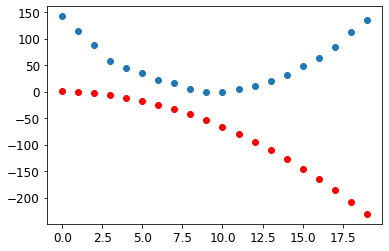

In [54]:
show_preds(pred)

**Step6: Loop through this proces multiple times**

In [55]:
def update_weights(params):
    pred = f(time, params)
    loss = mse(pred, speed)
    loss.backward()
    params.data -= lr*params.grad.data
    params.grad = None
    print(loss.item())
    return pred

In [56]:
for i in range(10): update_weights(params)

161.84002685546875
136.631591796875
112.7071304321289
90.9061508178711
72.66173553466797
59.900123596191406
53.48632049560547
51.39848327636719
50.90974044799805
50.809329986572266


50.78927993774414


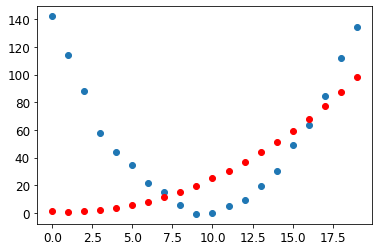

In [57]:
pred = update_weights(params)
show_preds(pred)

187.8580322265625
161.84002685546875
136.631591796875
112.7071304321289
90.9061508178711
72.66173553466797
59.900123596191406
53.48632049560547
51.39848327636719
50.90974044799805


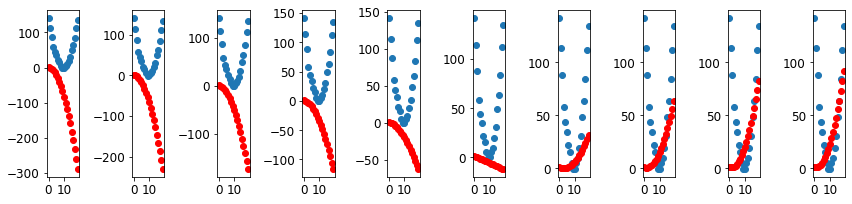

In [58]:
params = orig_params.detach().requires_grad_()
_,axs = plt.subplots(1,10,figsize=(12,3))
for ax in axs: show_preds(update_weights(params), ax)
plt.tight_layout()

# SGD for MNIST

First let us convert the images into vectors

In [59]:
threes_stacked.shape, sevens_stacked.shape, valid_threes.shape, valid_sevens.shape

(torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([1010, 28, 28]),
 torch.Size([1028, 28, 28]))

In [60]:
torch.cat([threes_stacked, sevens_stacked]).shape

torch.Size([12396, 28, 28])

In [61]:
threes_stacked.view(-1, 28*28).shape

torch.Size([6131, 784])

In [62]:
train_x = torch.cat([threes_stacked, sevens_stacked]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [63]:
train_y = tensor([1]*len(threes_stacked) + [0]*len(sevens_stacked)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [64]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [123]:
valid_x = torch.cat([valid_threes.float(), valid_sevens.float()]).view(-1, 28*28)
valid_y =  tensor([1]*len(valid_threes) + [0]*len(valid_sevens))
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038]))

In [124]:
valid_dset = list(zip(valid_x, valid_y))

Define the list of weights

In [67]:
w = torch.randn(28*28).requires_grad_()
w.shape

torch.Size([784])

Define bias

In [68]:
b = torch.randn(1).requires_grad_()
b

tensor([0.6863], requires_grad=True)

Create a function to do this initialization

In [69]:
def init_params(size): return torch.randn(size).requires_grad_()

In [70]:
w = init_params(28*28)
w.shape

torch.Size([784])

In [71]:
b = init_params(1)
b

tensor([-1.1151], requires_grad=True)

See what output it generates for one of the images, or define the function

In [72]:
(train_x[0]*w.T).sum()+b

tensor([-15.0592], grad_fn=<AddBackward0>)

See how to do matrix multiplication on the entire matrix of images

In [73]:
train_x @ w + b

tensor([-15.0592,  -6.4868, -14.2646,  ..., -14.2185,   0.6238,  -0.2753], grad_fn=<AddBackward0>)

In [74]:
def linear1(xb, w, b): return xb @ w + b

In [75]:
preds = linear1(train_x, w, b)
preds

tensor([-15.0592,  -6.4868, -14.2646,  ..., -14.2185,   0.6238,  -0.2753], grad_fn=<AddBackward0>)

Define the metric to check the prediction

In [76]:
corrects = (preds > 0.0).float() == train_y.T
corrects

tensor([[False, False, False,  ...,  True, False,  True]])

In [77]:
corrects.float().mean().item()

0.4543401002883911

In [78]:
def mnist_loss(pred, actual): return(pred-actual).abs()

In [79]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [80]:
mnist_loss(sigmoid(preds), train_y.T)

tensor([[1.0000e+00, 9.9848e-01, 1.0000e+00,  ..., 6.6832e-07, 6.5109e-01, 4.3161e-01]], grad_fn=<AbsBackward>)

In [81]:
def mnist_loss(pred, actual):
    pred = sigmoid(pred)
    return (pred-actual).abs().mean()

In [82]:
mnist_loss(linear1(train_x, w, b), train_y.T)

tensor(0.5478, grad_fn=<MeanBackward0>)

### Mini-batch

In [83]:
a = list(range(15))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [84]:
dl = DataLoader(a, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

**Steps to build the model**
- Predict values using the model
- Calculate the loss
- Take Gradient of the loss
- Update the parameters

In [85]:
w = init_params(28*28)
b = init_params(1)

In [86]:
preds = linear1(train_x[0:4], w, b)
preds.shape

torch.Size([4])

In [87]:
loss = mnist_loss(preds, train_y[0:4].T)
loss

tensor(0.5871, grad_fn=<MeanBackward0>)

In [88]:
loss.backward()

In [89]:
lr = 1

In [90]:
w.data -= lr*w.grad
b.data -= lr*b.grad
w.grad = None
b.grad = None

In [91]:
mnist_loss(linear1(train_x, w, b), train_y.T)

tensor(0.4630, grad_fn=<MeanBackward0>)

Now write the actual code for training

In [138]:
weights = init_params(28*28)
bias = init_params(1)

In [139]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [140]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [141]:
def calc_grad(xb, yb, model):
    preds = model(xb, w, b)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [142]:
def train_epoch(model, lr, w, b):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        
        w.data -= w.grad*lr
        b.data -= b.grad*lr
        w.grad.zero_()
        b.grad.zero_()

In [143]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [146]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb, w, b), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [147]:
validate_epoch(linear1)

0.5675

In [148]:
lr = 1.
train_epoch(linear1, lr, w, b)
validate_epoch(linear1)

0.7025

In [149]:
for i in range(20):
    train_epoch(linear1, lr, w, b)
    print(validate_epoch(linear1), end=' ')

0.8783 0.9345 0.9467 0.9564 0.9603 0.9637 0.9652 0.9667 0.9662 0.9672 0.9692 0.9701 0.9701 0.9701 0.9701 0.9706 0.9721 0.9721 0.9731 0.9731 